<a href="https://colab.research.google.com/github/anikch/paddy/blob/main/Pytorch%2Bswin_transformer%2Bautoaugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
%pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 30.4 MB/s 


In [4]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 37.8 MB/s 


In [5]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 34.9 MB/s 
     |████████████████████████████████| 596 kB 82.0 MB/s 
     |████████████████████████████████| 140 kB 90.9 MB/s 
     |████████████████████████████████| 1.1 MB 8.0 MB/s 
     |████████████████████████████████| 271 kB 91.7 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
     |████████████████████████████████| 144 kB 79.0 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [6]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.datasets as datasets
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchmetrics import Accuracy, ConfusionMatrix
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from torchvision.transforms import AutoAugment, AutoAugmentPolicy, InterpolationMode

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

from PIL import Image 
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import WeightedRandomSampler
from sklearn.model_selection import train_test_split

import timm
from torchinfo import summary
import posixpath
import pandas as pd

# **Exploratory Data Analysis**

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
colab= '/content/drive/MyDrive'
local= r'G:\My Drive'

code_runtime= colab

In [10]:
file1= 'thesis/dataset/paddy_doctor/train.csv'
inp_file = posixpath.join(code_runtime, file1)

df=pd.read_csv(inp_file)

df.head(5)

image_id                  label variety  age
0  100330.jpg  bacterial_leaf_blight   ADT45   45
1  100365.jpg  bacterial_leaf_blight   ADT45   45
2  100382.jpg  bacterial_leaf_blight   ADT45   45
3  100632.jpg  bacterial_leaf_blight   ADT45   45
4  101918.jpg  bacterial_leaf_blight   ADT45   45

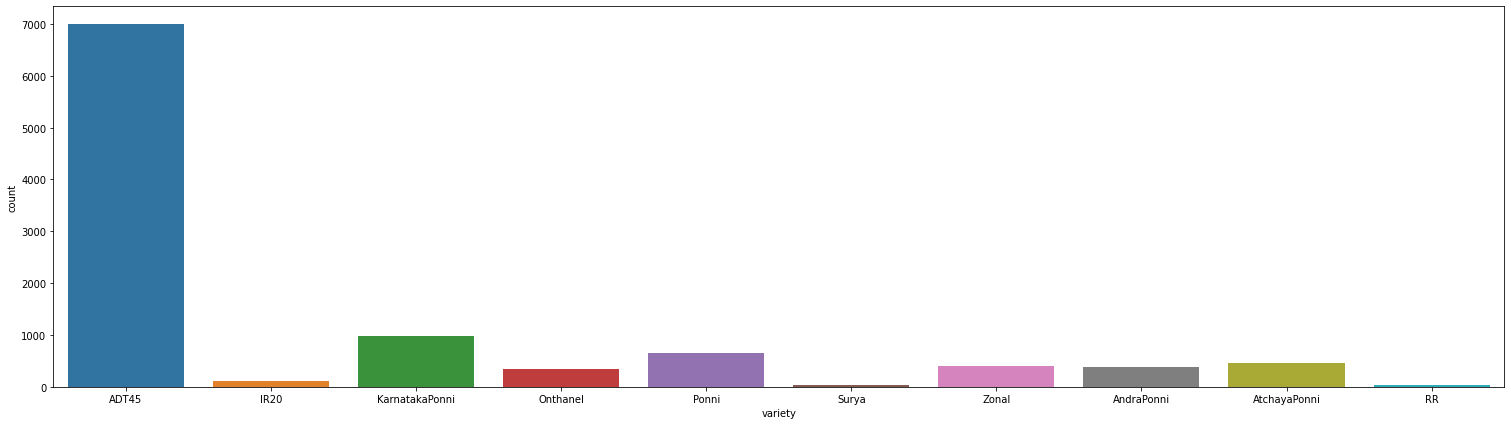

In [11]:
fig = plt.figure(figsize = (26,7))
sns.countplot(data = df, x = 'variety')

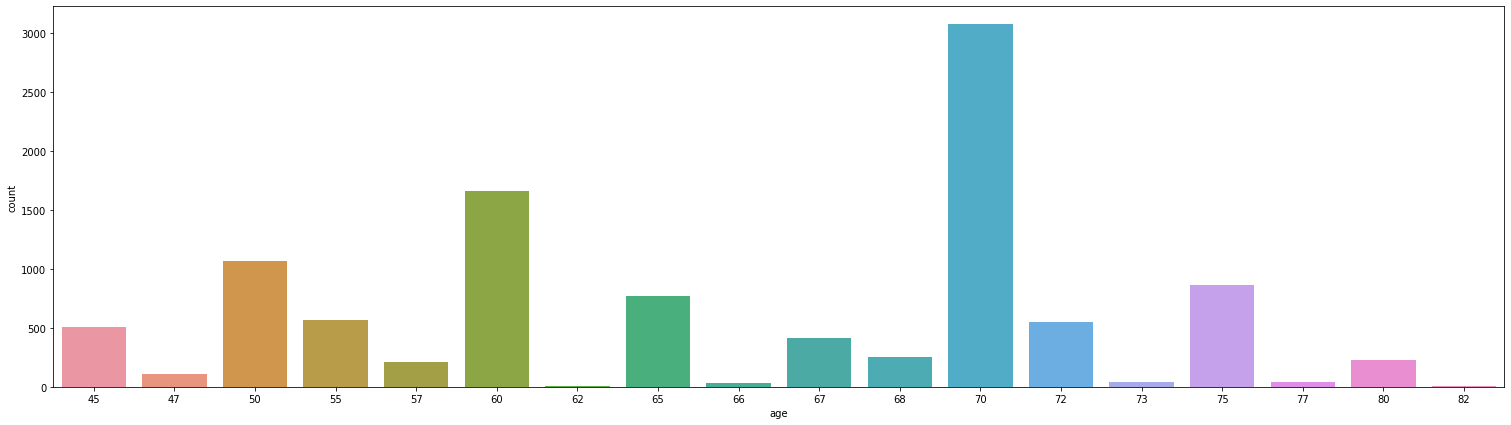

In [12]:
fig = plt.figure(figsize = (26,7))
sns.countplot(data = df, x = 'age')

# Parameters and Hyperparameters

In [13]:
train_path= 'thesis/dataset/paddy_doctor/train_images/'
test_path= 'thesis/dataset/paddy_doctor/test_images/'

In [14]:
train_files= posixpath.join(code_runtime, train_path)
test_files= posixpath.join(code_runtime, test_path)

In [15]:
class CONFIG:
    df_path = inp_file
    train_path = train_files
    test_path = test_files
    model_path = '{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}'
    split = [0.9, 0.1]
    batch_size = 16
    weight_decay = 1e-4
    learning_rate = 1e-4
    lr_patience = 2
    stop_patience = 3
    layers = 2
    classes = 10
    gpus = (1 if torch.cuda.is_available() else 0)
    num_epochs = 15
    accum = 64
    num_workers = 2
    shuffle = False

In [16]:
df = pd.read_csv(CONFIG.df_path)

# Label Encoding

In [17]:
labelencoder = LabelEncoder()
df['label_name'] = df['label']
df['label'] = labelencoder.fit_transform(df['label'])
print('classes encoded:', labelencoder.classes_)
display(df.head(5))

classes encoded: ['bacterial_leaf_blight' 'bacterial_leaf_streak'
 'bacterial_panicle_blight' 'blast' 'brown_spot' 'dead_heart'
 'downy_mildew' 'hispa' 'normal' 'tungro']


image_id  label variety  age             label_name
0  100330.jpg      0   ADT45   45  bacterial_leaf_blight
1  100365.jpg      0   ADT45   45  bacterial_leaf_blight
2  100382.jpg      0   ADT45   45  bacterial_leaf_blight
3  100632.jpg      0   ADT45   45  bacterial_leaf_blight
4  101918.jpg      0   ADT45   45  bacterial_leaf_blight

# Custom Dataset

In [18]:
class PaddyImageDataset(Dataset):
    
    def __init__(self, 
                 df = None, 
                 root_dir = None, 
                 transform = None):

        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        
        if df is not None:
            self.imgs = self.df["image_id"]
            self.labels = self.df["label"]

        
    def __len__(self):
        
        if self.df is not None:
            return len(self.df)
        else:
            return len(os.listdir(self.root_dir))
    
    def __getitem__(self, index):

        if self.df is not None:
            img_id = self.imgs[index]
            img_label = self.labels[index]
            img_label_name = self.df['label_name'][index]
            
            img_path = os.path.join(
                self.root_dir, img_label_name, img_id)
            
            with Image.open(img_path).convert('RGB') as image:               
                if self.transform is not None:
                    img = self.transform(image)
                    
            return img, torch.tensor(int(img_label))

        else:
            
            img_id = os.listdir(self.root_dir)[index]
            img_path = os.path.join(self.root_dir, img_id)
            
            with Image.open(
                os.path.join(img_path)).convert('RGB') as image:               
                if self.transform is not None:
                    img = self.transform(image)
                            
            return img

# WeightedRandomSamplers

In [19]:
def getWeightedRandomSampler(df):
    
    counts = np.bincount(df['label'])
    label_weights = 1. / counts
    weights = label_weights[df['label']]
    
    return WeightedRandomSampler(
        weights, num_samples = len(weights), replacement = True)

# Data Loaders

In [20]:
def get_loader(dataset, batch_size, sampler = None):
    
    loader = DataLoader(
            dataset, batch_size = batch_size)
    
    if sampler is not None:
        loader.__dict__['sampler'] = sampler
    
    return loader

In [21]:
df_train, df_val = train_test_split(
    df, stratify = df[['label', 'variety']], 
    test_size = (1.0 - CONFIG.split[0]), 
    random_state = 42)

df_train.reset_index(inplace = True)
df_val.reset_index(inplace = True)

In [22]:
display(df_train.head(5))
df_val.head(5)

index    image_id  label variety  age             label_name
0    323  105031.jpg      0   ADT45   72  bacterial_leaf_blight
1   6607  103464.jpg      7   ADT45   70                  hispa
2    278  101761.jpg      0   ADT45   72  bacterial_leaf_blight
3   8975  107053.jpg      8   ADT45   77                 normal
4   6192  108441.jpg      7   ADT45   50                  hispa

index    image_id  label variety  age             label_name
0   2711  100177.jpg      3   Ponni   47                  blast
1    408  103230.jpg      0    IR20   50  bacterial_leaf_blight
2   1417  100870.jpg      3   ADT45   60                  blast
3   4171  101952.jpg      5   ADT45   70             dead_heart
4   8370  108851.jpg      8   ADT45   60                 normal

In [23]:
train_sampler = getWeightedRandomSampler(df_train)
val_sampler = getWeightedRandomSampler(df_val)

In [24]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225])])

# AutoAugmentation

In [25]:
autoaugment = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.AutoAugment(
        policy = AutoAugmentPolicy.IMAGENET, 
        interpolation = InterpolationMode.BILINEAR,),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225])])

In [26]:
train_dataset = PaddyImageDataset(
    root_dir = CONFIG.train_path, 
    df = df_train, 
    transform = autoaugment)

print('Length of train dataset:', len(train_dataset))

val_dataset = PaddyImageDataset(
    root_dir = CONFIG.train_path, 
    df = df_val, 
    transform = autoaugment)

print('Length of val dataset:', len(val_dataset))

predict_dataset = PaddyImageDataset(
    root_dir = CONFIG.test_path, 
    transform = transform)

print('Length of predict dataset:', len(predict_dataset))

Length of train dataset: 9366
Length of val dataset: 1041
Length of predict dataset: 3469


In [27]:
train_dataloader = get_loader(
    dataset = train_dataset, 
    batch_size = CONFIG.batch_size,
    sampler = train_sampler)

val_dataloader = get_loader(
    dataset = val_dataset, 
    batch_size = CONFIG.batch_size,
    sampler = val_sampler)

predict_dataloader = get_loader(
    dataset = predict_dataset, 
    batch_size = CONFIG.batch_size,
    sampler = None)

# Data Visualization

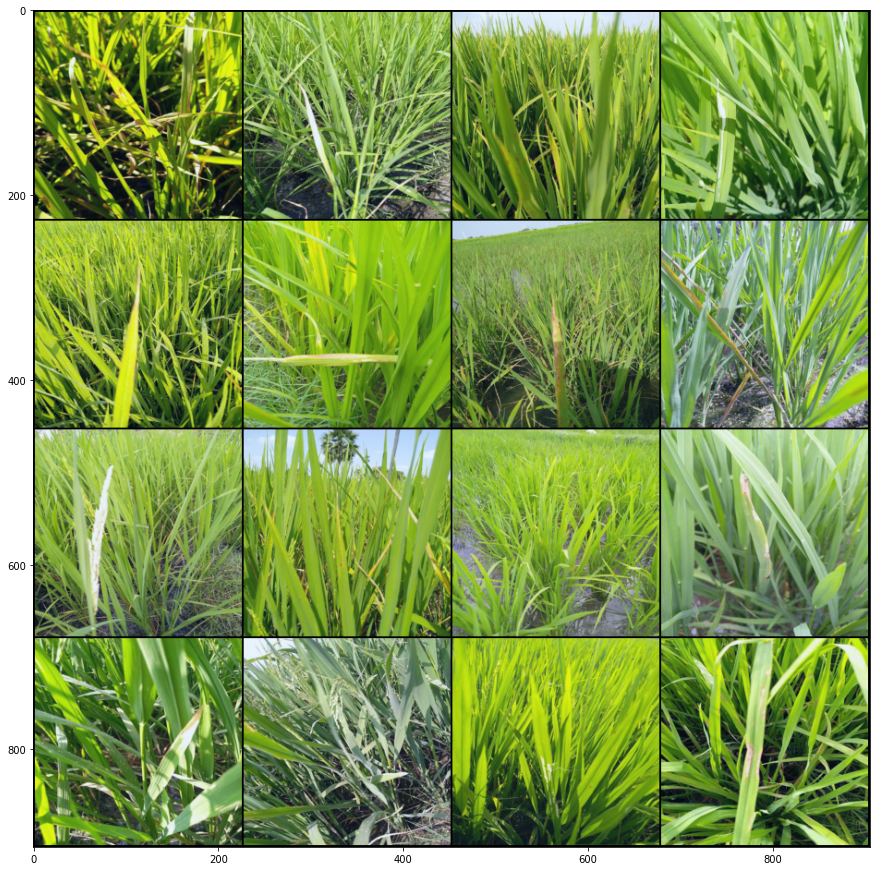

In [28]:
batch = next(iter(predict_dataloader))

grid_img = make_grid(
    batch, 
    nrow = 4,
    normalize = True)

plt.figure(figsize = (15,30))
plt.imshow(grid_img.permute(1, 2, 0))

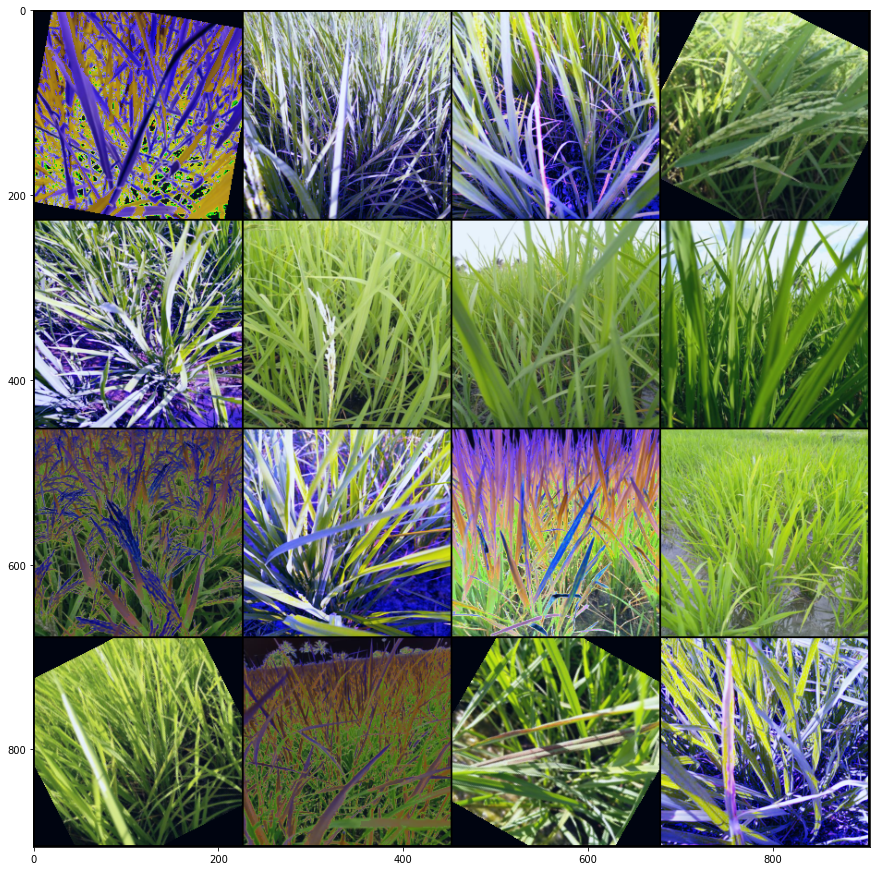

In [29]:
batch = next(iter(train_dataloader))

grid_img = make_grid(
    batch[0], 
    nrow = 4,
    normalize = True)

plt.figure(figsize = (15,30))
plt.imshow(grid_img.permute(1, 2, 0))

# Lightning Model

In [30]:
model = timm.create_model(
            "swin_base_patch4_window7_224_in22k", 
            pretrained = True)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224_22k.pth" to /root/.cache/torch/hub/checkpoints/swin_base_patch4_window7_224_22k.pth


In [31]:
summary(model,  input_size=(8, 3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
SwinTransformer                                    [8, 21841]                --
├─PatchEmbed: 1-1                                  [8, 3136, 128]            --
│    └─Conv2d: 2-1                                 [8, 128, 56, 56]          6,272
│    └─LayerNorm: 2-2                              [8, 3136, 128]            256
├─Dropout: 1-2                                     [8, 3136, 128]            --
├─Sequential: 1-3                                  [8, 49, 1024]             --
│    └─BasicLayer: 2-3                             [8, 784, 256]             --
│    │    └─Sequential: 3-1                        [8, 3136, 128]            397,896
│    │    └─PatchMerging: 3-2                      [8, 784, 256]             132,096
│    └─BasicLayer: 2-4                             [8, 196, 512]             --
│    │    └─Sequential: 3-3                        [8, 784, 256]             1,582,224
│    │    └─Pa

In [32]:
class PaddyDiseaseClassification(pl.LightningModule):


    def __init__(self,
                learning_rate,
                weight_decay,
                layers,
                patience,
                pretrained = True,
                classes = 10):

        super(PaddyDiseaseClassification, self).__init__()


        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.layers = layers
        self.patience = patience

        self.pretrained = pretrained
        self.classes = classes
        
        self.model = timm.create_model(
            "swin_base_patch4_window7_224_in22k", 
            pretrained = pretrained)
        
        self.model.head = nn.Linear(
            self.model.head.in_features, classes)

        self.save_hyperparameters()

        self.loss = nn.CrossEntropyLoss()

        self.train_acc = Accuracy(num_classes = classes)
        self.val_acc = Accuracy(num_classes = classes)
        
        self.finetune()
        
    def finetune(self):

        for param in list(self.model.children())[:-1]:
            for p in param.parameters():
                p.requires_grad = False
    
        for param in list(self.model.layers._modules['3'].blocks):
            for p in param.parameters():
                p.requires_grad = True

        if self.layers is not 0:
            for param in list(self.model.layers._modules['2'].blocks)[-self.layers:]:
                for p in param.parameters():
                    p.requires_grad = True


    def configure_optimizers(self):

        optimizer = torch.optim.Adam(
            self.model.parameters(), 
            lr = self.learning_rate, 
            weight_decay = self.weight_decay)
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode = 'max', 
            factor = 0.2, 
            patience = self.patience, 
            verbose = True)

        return {
           'optimizer': optimizer,
           'lr_scheduler': scheduler,
           'monitor': 'val_acc' 
       }

    
    def forward(self, images):
        
        output = self.model(images)
        return output
        

    def training_step(self, batch, batch_idx):

        images, labels = batch

        output = self.model(images)
        train_loss = self.loss(output, labels)

        self.log(
            name = 'train_loss',
            value = train_loss,
            on_step = False,
            on_epoch = True,
            prog_bar = True)

        train_acc = self.train_acc(output, labels)
        
        self.log(
            name = "train_acc",
            value = train_acc,
            on_step = False,
            on_epoch = True,
            prog_bar = True)

        return train_loss


    def validation_step(self, batch, batch_idx):

        images, labels = batch
        
        output = self.model(images)
        val_loss = self.loss(output, labels)

        val_acc = self.val_acc(output, labels)

        return {'val_loss': val_loss,
                'val_acc':val_acc,
                'log': {'val_loss': val_loss}}

    def validation_epoch_end(self, outputs):

        loss = torch.stack([o['val_loss'] for o in outputs], 0).mean()
        acc = torch.stack([o['val_acc'] for o in outputs], 0).mean()

        out = {'val_loss': loss,
               'val_acc': acc}

        self.log(
            name = 'val_loss',
            value = loss,
            on_epoch = True,
            prog_bar = True)

        self.log(
            name = 'val_acc',
            value = acc,
            on_epoch = True,
            prog_bar = True)

        return {**out, 'log': out}
    
    

# Model Training

In [33]:
model = PaddyDiseaseClassification(
    learning_rate = CONFIG.learning_rate,
    weight_decay = CONFIG.weight_decay,
    layers = CONFIG.layers,
    patience = CONFIG.lr_patience,
    classes = CONFIG.classes)

In [34]:
summary(
    model, 
    input_size = (16, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
PaddyDiseaseClassification                              [16, 10]                  --
├─SwinTransformer: 1-1                                  [16, 10]                  --
│    └─PatchEmbed: 2-1                                  [16, 3136, 128]           --
│    │    └─Conv2d: 3-1                                 [16, 128, 56, 56]         (6,272)
│    │    └─LayerNorm: 3-2                              [16, 3136, 128]           (256)
│    └─Dropout: 2-2                                     [16, 3136, 128]           --
│    └─Sequential: 2-3                                  [16, 49, 1024]            --
│    │    └─BasicLayer: 3-3                             [16, 784, 256]            (529,992)
│    │    └─BasicLayer: 3-4                             [16, 196, 512]            (2,108,560)
│    │    └─BasicLayer: 3-5                             [16, 49, 1024]            58,892,832
│    │    └─BasicLayer: 3-6 

In [35]:
early_stop_callback = EarlyStopping(
                        monitor = "val_acc",
                        min_delta = 0.00,
                        patience = CONFIG.stop_patience,
                        verbose = False,
                        mode = "max")

model_checkpoint = ModelCheckpoint(
                        monitor = 'val_acc',
                        save_top_k = 1,
                        save_weights_only = True,
                        filename = CONFIG.model_path,
                        verbose = False,
                        mode = 'max')

In [36]:
trainer = Trainer(
    auto_lr_find = True,
    gpus = CONFIG.gpus,
    max_epochs = CONFIG.num_epochs,
    accumulate_grad_batches = CONFIG.accum,
    callbacks = [model_checkpoint, 
                 early_stop_callback])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [37]:
trainer.fit(
    model = model, 
    train_dataloaders = train_dataloader, 
    val_dataloaders = val_dataloader)

Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SwinTransformer  | 86.8 M
1 | loss      | CrossEntropyLoss | 0     
2 | train_acc | Accuracy         | 0     
3 | val_acc   | Accuracy         | 0     
-----------------------------------------------
31.5 M    Trainable params
55.2 M    Non-trainable params
86.8 M    Total params
347.014   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [38]:
trainer.validate(dataloaders=val_dataloader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1447: UserWarning: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `validate(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at /content/lightning_logs/version_0/checkpoints/epoch=14-val_loss=0.1577-val_acc=0.9574.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/lightning_logs/version_0/checkpoints/epoch=14-val_loss=0.1577-val_acc=0.9574.ckpt
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `n

Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9498106241226196
        val_loss            0.17420867085456848
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_acc': 0.9498106241226196, 'val_loss': 0.17420867085456848}]

# Model Inference

In [ ]:
predictions = trainer.predict(
    model = model, dataloaders = predict_dataloader)

Predicting: 521it [00:00, ?it/s]

In [ ]:
flag = True
for tensor in predictions:
    if flag == True:
        stack = tensor
        flag = False
    else:
        stack = torch.concat(
            [stack,tensor], axis = 0)

In [ ]:
submission = pd.DataFrame()
submission['image_id'] = pd.DataFrame(os.listdir(CONFIG.test_path))
submission['label'] = pd.DataFrame(np.argmax(stack, axis = 1).numpy().astype('int'))

In [ ]:
submission['label'] = labelencoder.inverse_transform(submission['label'])
submission.head(10)

image_id                  label
0  200607.jpg                 normal
1  202733.jpg                 normal
2  200207.jpg  bacterial_leaf_streak
3  203024.jpg                 tungro
4  203056.jpg                  hispa
5  202751.jpg                  blast
6  201191.jpg                  blast
7  200912.jpg             dead_heart
8  200067.jpg                  blast
9  201689.jpg                  hispa

In [ ]:
submission.to_csv('submission.csv', index = False)